In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla
import scipy.sparse as sp
import kwant
import tinyarray

## Defining Dots

In [2]:
lat = kwant.lattice.honeycomb(a = 1.0, norbs=2)
a_lat, b_lat = lat.sublattices
nnn_hoppings_a = (((-1, 0), a_lat, a_lat), ((0, 1), a_lat, a_lat), ((1, -1), a_lat, a_lat))
nnn_hoppings_b = (((1, 0), b_lat, b_lat), ((0, -1), b_lat, b_lat), ((-1, 1), b_lat, b_lat))
nnn_hoppings_all = nnn_hoppings_a + nnn_hoppings_b
lat_neighbors_2 = [kwant.builder.HoppingKind(*hop) for hop in nnn_hoppings_all]

def atan(y, x):
    ans = np.arctan2(y, x)
    if type ( x + 0.0) == type(y+0.0) and type(x+0.0) in [float, np.float64, np.float128, np.float_]:

        if ans < 0: return 2*np.pi + ans
        else: return ans

    elif type(x) == type(y) and type(x) == type(np.array([])) :
        ans[ans < 0] += 2*np.pi
        return ans

    else: raise TypeError("atan is getting neither floats nor arrays")


def create_graphene_circular_system(r, a=1.0, norb=1, t_prime = 0.0, p_edge = 0.0, U0 = 0.0):

    def deformed_circle(pos):
      R = np.linalg.norm(np.array([*pos]))
      angle = atan(pos[1], pos[0])
      return R < r + 0.2*r*np.sin(angle) + 0.05*r*np.sin(2*angle) - 0.025*r*np.sin(3*angle) + 0.02*r*np.sin(4*angle) - 0.01*r*np.sin(5*angle)

    sys = kwant.Builder()
    sys[lat.shape(deformed_circle, (0, 0))] = 0
    sys[lat.neighbors(n=1)] = -1.0

    for __ in range(3):
        sites = list(sys.sites())
        for s in sites:
            num_connections = sum(1 for _ in sys.neighbors(s))
            if num_connections == 1 or num_connections == 0: del sys[s]

    sites = list(sys.sites())
    edges = []
    for s in sites:
        num_connections = sum(1 for _ in sys.neighbors(s))
        if num_connections < 3: edges.append(s)
    print("Number of edges: ", len(edges))
    
    pp = True
    for edge_sites in edges:
      random_number = np.random.rand()
      if random_number < p_edge:
        if pp: 
            print("Edge site")
            pp = False
        sys[edge_sites] = U0
    
    

    if not np.allclose(t_prime, 0):
        sys[lat_neighbors_2] = -t_prime

    return sys

Number of edges:  27
Number of edges:  27
Number of edges:  27
Edge site


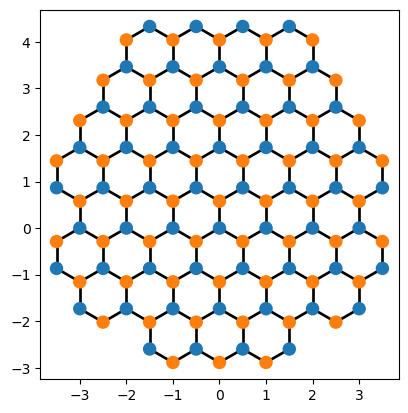

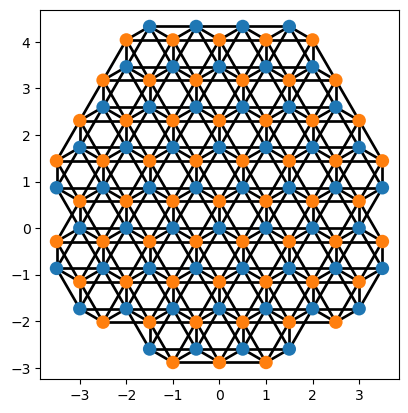

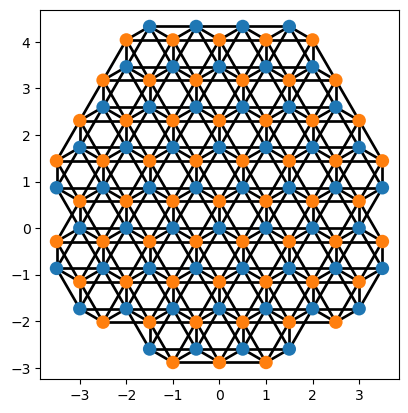

In [40]:
circular_dot = create_graphene_circular_system(r=4., t_prime=0.0)
circular_dot_edge1 = create_graphene_circular_system(r=4., t_prime=0.1, p_edge=0.0, U0=0.0)
circular_dot_edge2 = create_graphene_circular_system(r=4., t_prime=0.1, p_edge=1.0, U0=0.1)
kwant.plot(circular_dot)
kwant.plot(circular_dot_edge1)
kwant.plot(circular_dot_edge2)
plt.show()

In [41]:
gqd = circular_dot.finalized()
gqde1 = circular_dot_edge1.finalized()
gqde2 = circular_dot_edge2.finalized()
N = len(gqd.sites)
N

113

In [42]:
h = gqd.hamiltonian_submatrix(sparse=True)
he1 = gqde1.hamiltonian_submatrix(sparse=True)
he2 = gqde2.hamiltonian_submatrix(sparse=True)

In [43]:
energies_ref, eigs_ref= sla.eigsh(h, k=N-2, return_eigenvectors=True, sigma=1e-16)

In [44]:
energies, eigs= sla.eigsh(he1, k=N-2, return_eigenvectors=True, sigma=1e-16)

In [45]:
energies2, eigs2= sla.eigsh(he2, k=N-2, return_eigenvectors=True, sigma=1e-16)

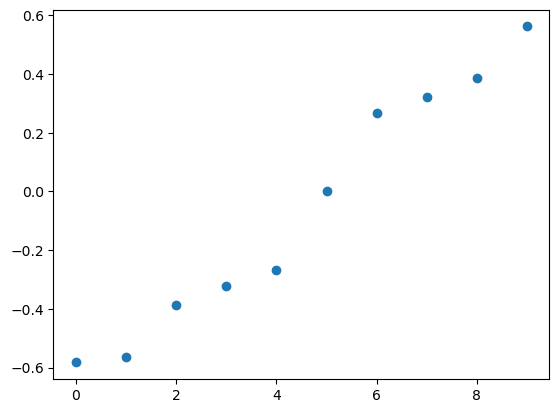

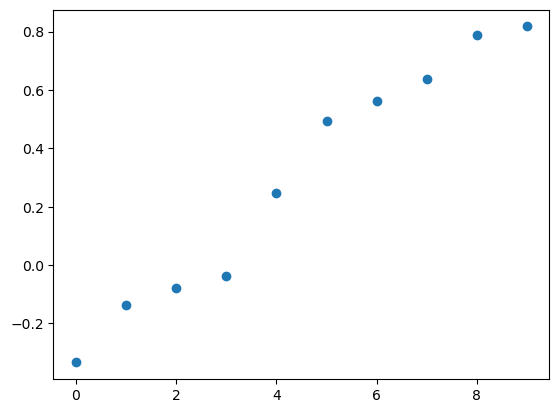

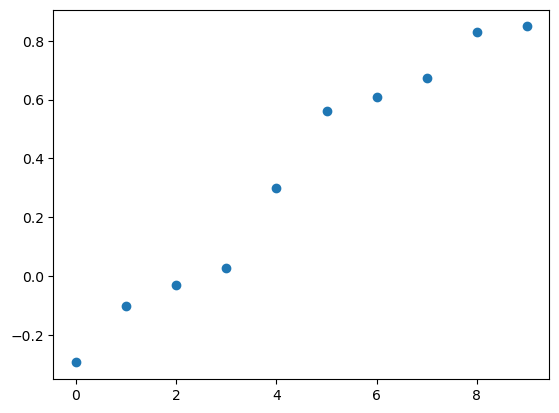

In [54]:
def scatter_plot(arr, show=False):
    plt.scatter(range(len(arr)), np.sort(arr))
    if show: plt.show()
start = 55-5
finish = 55+5
scatter_plot(np.sort(energies_ref)[start:finish], show=True)
scatter_plot(np.sort(energies)[start:finish], show=True)
scatter_plot(np.sort(energies2)[start:finish], show=True)
plt.show()

In [59]:
# if len(energies_ref) != len(energies):
eigs_ref = eigs_ref.T
eigs = eigs.T
eigs2 = eigs2.T
eigs_ref = eigs_ref[np.argsort(energies_ref)]
eigs = eigs[np.argsort(energies)]
eigs2 = eigs2[np.argsort(energies2)]


/tmp/ipykernel_407558/229697550.py:5: RuntimeWarning:

The plotted data contains 1.69% of values overflowing upper limit 0.0682179 



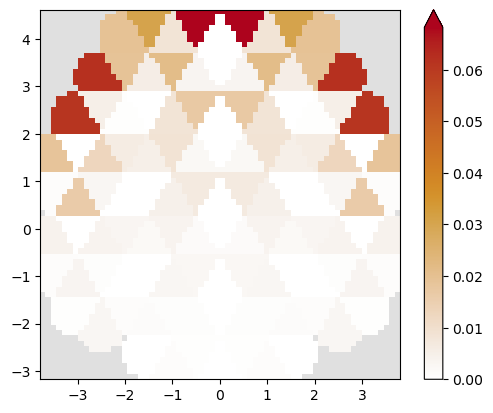

/tmp/ipykernel_407558/229697550.py:6: RuntimeWarning:

The plotted data contains 0.82% of values overflowing upper limit 0.0495089 



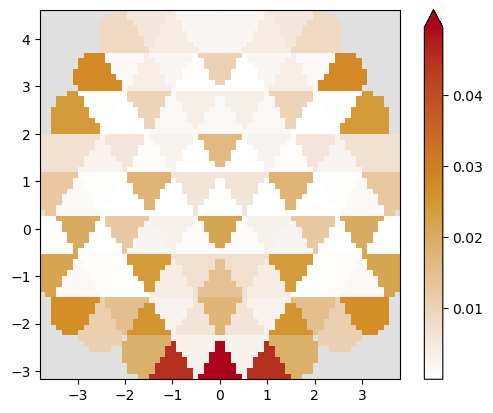

/tmp/ipykernel_407558/229697550.py:7: RuntimeWarning:

The plotted data contains 0.82% of values overflowing upper limit 0.0458563 



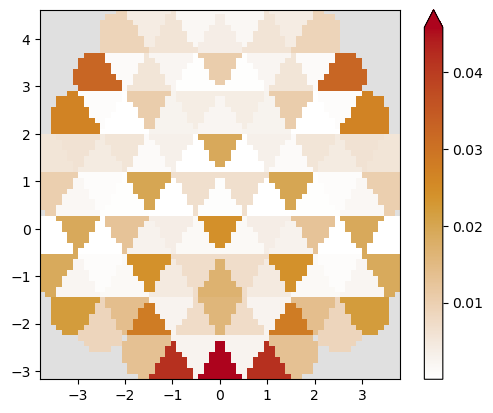

In [66]:
# zero-energy states = {360, 361, 362}
# sort eigenvectors by energy
s = 55+1

kwant.plotter.map(gqd, np.abs(eigs_ref[s])**2, oversampling=5)
kwant.plotter.map(gqde1, np.abs(eigs[s])**2, oversampling=5)
kwant.plotter.map(gqde2, np.abs(eigs2[s])**2, oversampling=5)
plt.show()

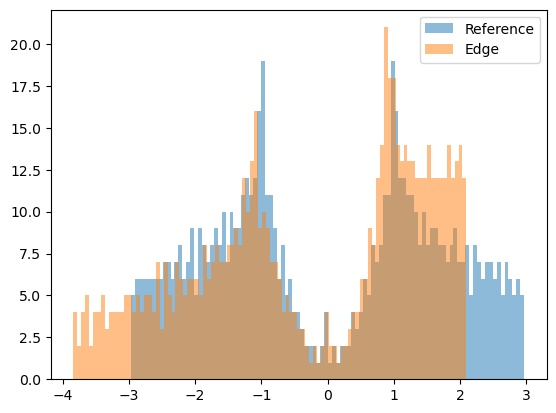

In [58]:
# plt.hist(energies-0.3, bins=100, alpha=0.5, label='No edge')
plt.hist(energies_ref, bins=100, alpha=0.5, label='Reference')
plt.hist(energies2-0.3, bins=100, alpha=0.5, label='Edge')
plt.legend()
plt.show()